In [1]:
import os
import yfinance as yf
import pandas as pd

# Path to the neighboring 'data' folder in the local repository
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))


In [2]:

# Ticker für Apple und den DAX
apple_ticker = 'AAPL'
dax_ticker = '^GDAXI'  # DAX-Index auf Yahoo Finance

# Abrufen der historischen Daten (z. B. der letzten 5 Jahre)
apple_data = yf.download(apple_ticker, start='2020-01-01', end='2025-01-01')
dax_data = yf.download(dax_ticker, start='2020-01-01', end='2025-01-01')

# Ausgabe der ersten 5 Zeilen der heruntergeladenen Daten
print("Apple-Daten:\n", apple_data.head())
print("\nDAX-Daten:\n", dax_data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^GDAXI']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Apple-Daten:
 Empty DataFrame
Columns: [(Adj Close, AAPL), (Close, AAPL), (High, AAPL), (Low, AAPL), (Open, AAPL), (Volume, AAPL)]
Index: []

DAX-Daten:
 Empty DataFrame
Columns: [(Adj Close, ^GDAXI), (Close, ^GDAXI), (High, ^GDAXI), (Low, ^GDAXI), (Open, ^GDAXI), (Volume, ^GDAXI)]
Index: []


In [3]:
print(data_path)
# Optional: Speichern der Daten in CSV-Dateien
apple_data.to_csv(data_path + '/' + 'apple_stock_data.csv')
dax_data.to_csv(data_path + '/' + 'dax_stock_data.csv')


/Users/tillo/Repositorys/stock-price-rnn/data


In [4]:

# Neu benennen der Spalten 
# Das Datum ist bereits index, das heist es ist bereits im date time format passend für das RNN 
apple_data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

dax_data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Optional: Überprüfen, ob alles korrekt umgewandelt wurde
print(apple_data.head())
print(dax_data.head())

ValueError: Length mismatch: Expected axis has 6 elements, new values have 5 elements

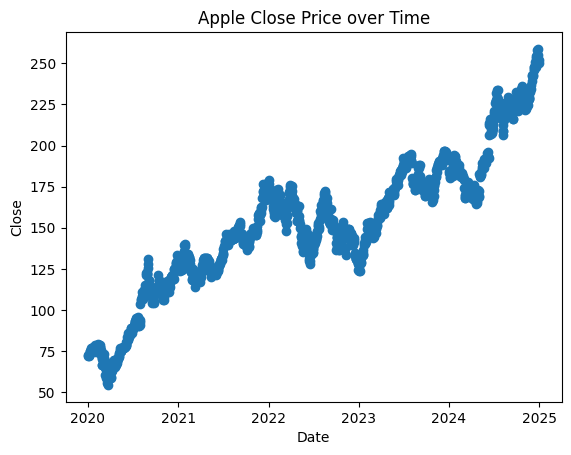

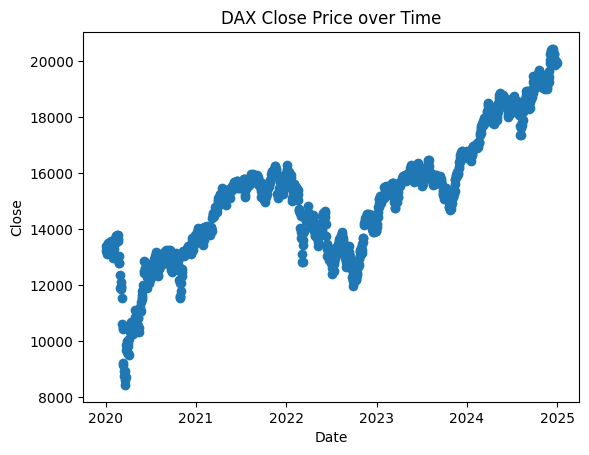

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(apple_data.index, apple_data['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Apple Close Price over Time')
plt.show()

plt.scatter(dax_data.index, dax_data['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('DAX Close Price over Time')
plt.show()



In [ ]:
# Skalieren der Closing Price column um den datensatz für ein RNN vorzubereiten 

from sklearn.preprocessing import MinMaxScaler
import numpy as np

def prepare_sequences(data, sequence_length=10):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[['Close']])

    sequences = []
    targets = []

    for i in range(len(data_scaled) - sequence_length):
        sequences.append(data_scaled[i:i+sequence_length])
        targets.append(data_scaled[i+sequence_length])

    return np.array(sequences), np.array(targets), scaler

X, y, scaler = prepare_sequences(apple_data)

In [ ]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

model = RNNModel()


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(30):
    for seqs, targets in dataloader:
        outputs = model(seqs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0002
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0007
Epoch 4, Loss: 0.0002
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0003
Epoch 8, Loss: 0.0001
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0003
Epoch 11, Loss: 0.0005
Epoch 12, Loss: 0.0003
Epoch 13, Loss: 0.0001
Epoch 14, Loss: 0.0001
Epoch 15, Loss: 0.0001
Epoch 16, Loss: 0.0003
Epoch 17, Loss: 0.0005
Epoch 18, Loss: 0.0002
Epoch 19, Loss: 0.0001
Epoch 20, Loss: 0.0003
Epoch 21, Loss: 0.0006
Epoch 22, Loss: 0.0001
Epoch 23, Loss: 0.0002
Epoch 24, Loss: 0.0003
Epoch 25, Loss: 0.0003
Epoch 26, Loss: 0.0001
Epoch 27, Loss: 0.0003
Epoch 28, Loss: 0.0003
Epoch 29, Loss: 0.0003
Epoch 30, Loss: 0.0002


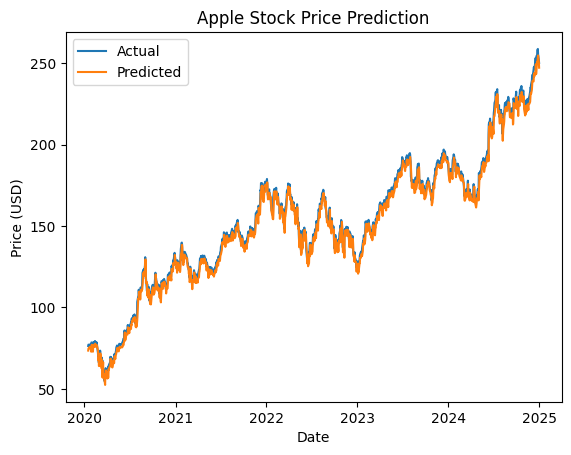

In [ ]:
# Vergleich wie gut das RNN die historischen daten vorhersagen kann 

import matplotlib.pyplot as plt

with torch.no_grad():
    predictions = model(X_tensor).numpy()

# Rückskalieren
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y)

# Verwende den DateTime-Index für den Plot
plt.plot(apple_data.index[-len(actual_prices):], actual_prices, label='Actual')
plt.plot(apple_data.index[-len(predicted_prices):], predicted_prices, label='Predicted')

plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [ ]:
import torch

def predict_future(model, last_sequence, future_steps, scaler):
    """
    Vorhersage der zukünftigen Preise mit dem RNN-Modell.

    Parameters:
        model (nn.Module): Das trainierte RNN-Modell.
        last_sequence (numpy.ndarray): Die letzten historischen Werte (normalisierte Daten).
        future_steps (int): Die Anzahl der zu prognostizierenden zukünftigen Zeitpunkte.
        scaler (MinMaxScaler): Der Scaler, der zum Normalisieren der Daten verwendet wurde.

    Returns:
        numpy.ndarray: Die vorhergesagten zukünftigen Werte (in Originalskala).
    """
    model.eval()  # Setzt das Modell in den Evaluierungsmodus
    predicted_prices = []
    current_sequence = last_sequence  # Die letzte bekannte Sequenz

    for _ in range(future_steps):
        with torch.no_grad():
            # Die Eingabedaten in den richtigen Tensor umwandeln
            X_input = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0)  # Batch-Dimension hinzufügen
            X_input = X_input.unsqueeze(-1)  # Input wird zu (1, sequence_length, 1), passend für das Modell
            
            # Vorhersage aus dem Modell
            prediction = model(X_input).squeeze().numpy()  # Vorhersage aus dem Modell
            predicted_prices.append(prediction)

            # Die Vorhersage zu den Eingabedaten hinzufügen und die älteste Wert entfernen
            current_sequence = np.append(current_sequence[1:], prediction).reshape(-1, 1)

    # Rückskalieren der Vorhersagen in die Originalpreise
    predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

    return predicted_prices


In [ ]:
# Letzte historische Daten (z.B. die letzten 10 Tage)
last_sequence = apple_data['Close'][-10:].values  # Hier die letzten 10 Tage, anpassen je nach Modell

# Die Anzahl der Tage, für die du vorhersagen möchtest
future_steps = 30  # z.B. für die nächsten 30 Tage

# Vorhersage der zukünftigen Preise
predicted_future_prices = predict_future(model, last_sequence, future_steps, scaler)

# Plotten der tatsächlichen und vorhergesagten zukünftigen Preise
plt.plot(apple_data.index[-len(predicted_future_prices):], predicted_future_prices, label='Predicted Future Prices', color='orange')
plt.title('Apple Stock Price Prediction for Future')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


ValueError: RNN: Expected input to be 2D or 3D, got 4D tensor instead

In [ ]:

import matplotlib.pyplot as plt

with torch.no_grad():
    predictions = model(X_tensor).numpy()

# Rückskalieren
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y)

# Verwende den DateTime-Index für den Plot
plt.plot(apple_data.index[-len(actual_prices):], actual_prices, label='Actual')
plt.plot(apple_data.index[-len(predicted_prices):], predicted_prices, label='Predicted')

plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
